*DATA MODELING*

In [53]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

*Time Series Tasks*

1. Convert the longitudinal blood pressure measurements into a proper time series:
- Create a pandas Series with DatetimeIndex using visit_date
- Handle any missing or duplicate measurements appropriately

Tips:

- Use pd.to_datetime() with format='%Y-%m-%d' for reliable parsing*
- Handle duplicates with duplicated() and appropriate aggregation*
- Consider timezone handling with tz_localize() if needed*
- Use interpolate() or fillna() for missing values*

In [55]:
# load dataset
longitudinal_df = pd.read_csv('patient_longitudinal.csv', sep='\t')

# create pandas series with DateTimeIndex using visit_date
longitudinal_df['visit_date'] = pd.to_datetime(longitudinal_df['visit_date'])

# handle missing or dupicates
longitudinal_df = longitudinal_df.groupby(['patient_id', 'visit_date']).mean().reset_index()

# make visit_date a datetimeindex
longitudinal_df.set_index('visit_date', inplace=True)

longitudinal_df['bp_systolic'] = longitudinal_df['bp_systolic'].interpolate()

2. Analyze blood pressure trends:

- Resample the data to monthly frequency using mean aggregation
- Calculate 3-month moving averages to smooth out short-term fluctuations
- Visualize both the original and smoothed trends

Tips:

- Use resample('ME').mean() for month-end frequency
- Add min_periods to rolling() to handle edge cases
- Consider interpolate() method for gaps
- Use ewm() for exponential weighted alternatives

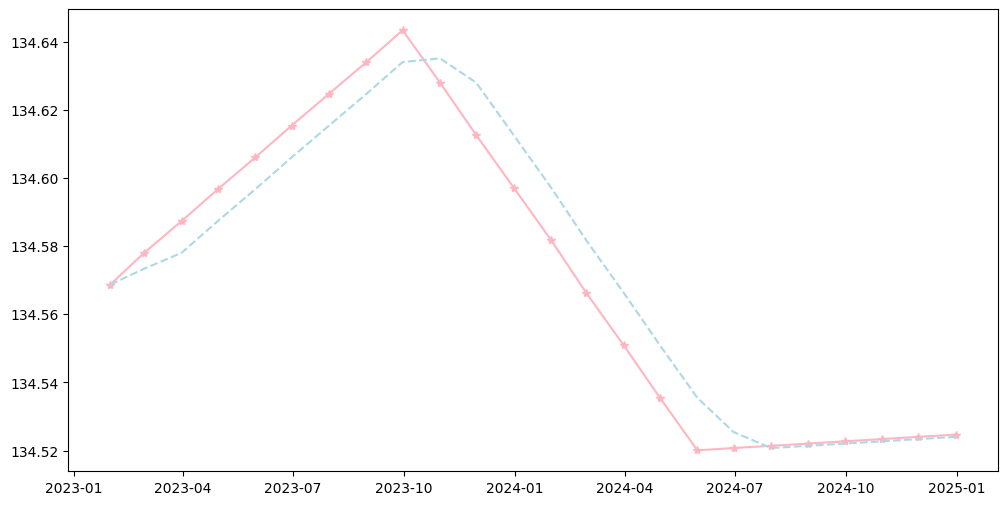

In [69]:
# resample monthly frequency 
monthFreq = longitudinal_df['bp_systolic'].resample('ME').mean() 

# missing values
monthFreq = monthFreq.interpolate()

# 3 month moving averages 
threeMonthAvg = monthFreq.rolling(window = 3, min_periods = 1).mean() 

# visualization of original and smoothed trends
plt.figure(figsize = (12,6))
plt.plot(monthFreq, label = 'Original Blood Pressure Monthly Trend', marker = '*', color = "lightpink")
plt.plot(threeMonthAvg, label = '3 Month Moving Average Trend', linestyle = '--', color = "lightblue") 

**INTERPRETATION: The original trend and smoooth trend follow a very similar path. The original trend is definitely more rigid looking. Meanwhile, the smoothened our trend is much less bumpy.**

*Statistical Modeling Tasks*

1. Analyze factors affecting baseline blood pressure:

- Use statsmodels OLS to predict bp_systolic
- Include age, bmi, smoking, and diabetes as predictors
- Interpret the coefficients and their p-values
- Assess model fit using R-squared and diagnostic plots

Tips:

- Create feature matrix X with predictors and add constant term using sm.add_constant()
- Use sm.OLS(y, X).fit() to fit the model
- Use summary() to examine p-values and confidence intervals
- Plot residuals vs fitted values and Q-Q plot
- Consider robust standard errors with HC3 covariance type

                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     150.0
Date:                Thu, 05 Dec 2024   Prob (F-statistic):          2.04e-100
Time:                        01:03:43   Log-Likelihood:                -3700.7
No. Observations:                1000   AIC:                             7411.
Df Residuals:                     995   BIC:                             7436.
Df Model:                           4                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4929      1.973     54.996      0.0

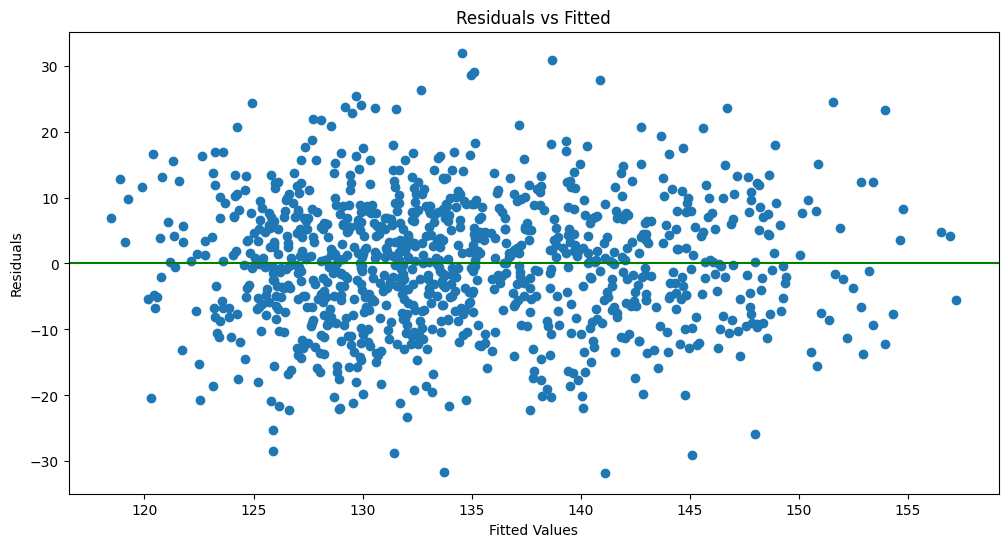

<Figure size 1200x600 with 0 Axes>

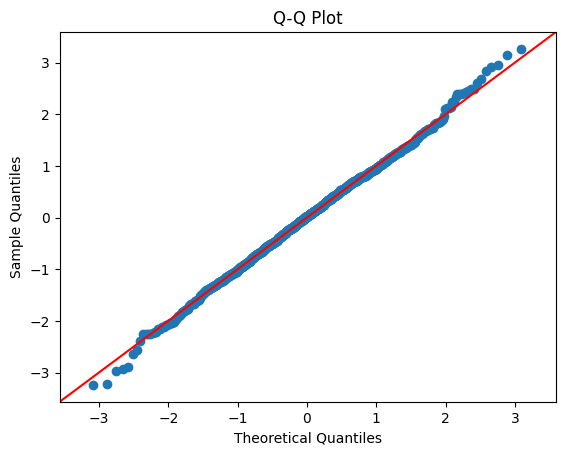

In [76]:
baseline_df = pd.read_csv('patient_baseline.csv', sep='\t') #load baseline data

 # BP is dependent variable
y = baseline_df['bp_systolic']
# predictors 
X = baseline_df[['age', 'bmi', 'smoking','diabetes']] 
# constant term
X = sm.add_constant(X)  

# fit the OLS model
model = sm.OLS(y, X).fit(cov_type = 'HC2')
print(model.summary()) 

# plot residuals vs fitted values 
plt.figure(figsize=(12, 6))

# resid vs fitted plot
plt.scatter(x=model.fittedvalues, y=model.resid)
plt.axhline(y=0, color='green', linestyle='-')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')

plt.show()

# Q-Q Plot 
plt.figure(figsize=(12, 6))
sm.qqplot(model.resid, line='45', fit=True) 
plt.title('Q-Q Plot')


plt.show()

**INTERPRETATION: The scatterplot has points that are randomly scattered with no pattern. This indicates that the model accurately captures the relationship between the fitted values and the residual values. The QQplot points are all mostly on the red line. This indicates a mostly normal distribution.**

2. Model treatment effectiveness:

- Fit a GLM with binomial family to predict treatment success
- Use baseline characteristics and adherence as predictors
- Report odds ratios and their confidence intervals
- Assess model fit using deviance and diagnostic plots

Tips:

- Create feature matrix X with predictors and add constant term
- Use sm.GLM(y, X, family=sm.families.Binomial()).fit()
- Get odds ratios with np.exp(params)
- Check residual deviance vs null deviance
- Use influence() to detect influential observations

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -648.23
Date:                Thu, 05 Dec 2024   Deviance:                       1296.5
Time:                        01:12:18   Pearson chi2:                     999.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.03760
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0987      0.680     -3.086      0.0

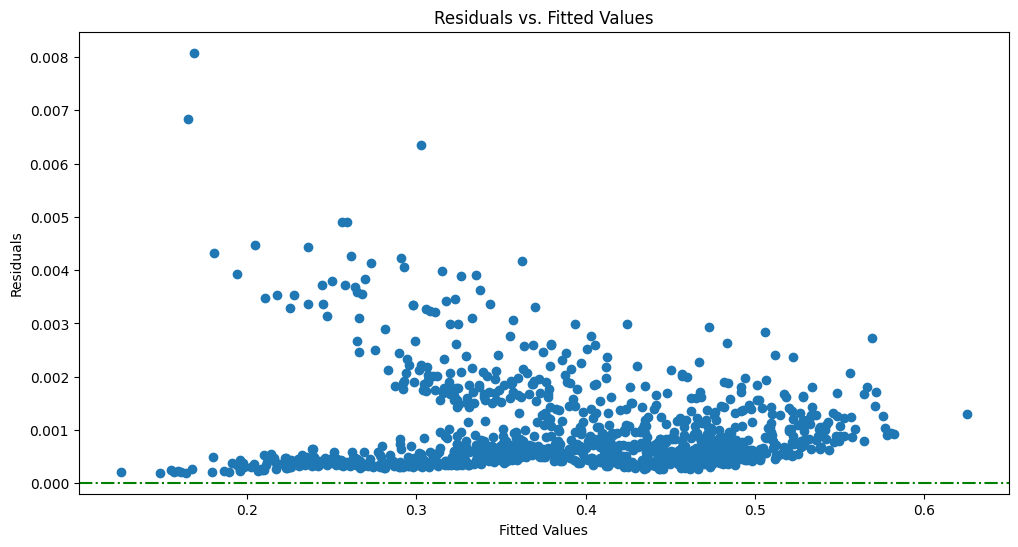

In [79]:
treatment_df = pd.read_csv('patient_treatment.csv', sep='\t') #load treatment data

# treatment outcome as dependent variable
y = treatment_df['outcome'] 
# predictors
X = treatment_df[['age', 'bmi', 'smoking','diabetes', 'adherence']]
# constant term
X = sm.add_constant(X) 

# fit the GLM model
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(model.summary())

# odds ratios and 95% confidence intervals
params = model.params
conf = model.conf_int()
odds_ratios = np.exp(params)
conf_intervals = np.exp(conf)
odds_ratios_df = pd.DataFrame({
    'Odds Ratio': odds_ratios,
    '2.5%': conf_intervals[0],
    '97.5%': conf_intervals[1]
})
print("\nOdds Ratios and 95% Confidence Intervals:")
print(odds_ratios_df)

# residual deviance vs null deviance
print("\nResidual Deviance:", model.deviance)
print("Null Deviance:", model.null_deviance)

# influential observations 
influence = model.get_influence()
cooks = influence.cooks_distance[0] 

# plot
plt.figure(figsize = (12,6))

plt.scatter(model.fittedvalues, cooks) 
plt.axhline(y=0, color='green', linestyle='dashdot')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()



**INTERPRETATION: From this graph, the variance of the residuals is not constant across the range of fitted values. Many of the points are very close to 0.000, which means that the mode is neither under nor over predicting.**